In [2]:
import torch
# @title device
def get_device():
  if torch.cuda.is_available():
      device = torch.device("cuda")
      print("CUDA is available. Using GPU.")
  else:
      device = torch.device("cpu")
      print("CUDA is not available. Using CPU.")
  return device
device=get_device()

CUDA is available. Using GPU.


# Preprocessing

In [3]:
# @title code
from os import makedirs
import torch
import math
import os
import string
import shutil
import subprocess
import pandas as pd
import numpy as np
import pandas as pd

def get_x(value):

    if isinstance(value, str):
        return float(value.split("/")[0])
    elif isinstance(value, float):
        return value

def get_y(value):

    if isinstance(value, str):
        return float(value.split("/")[1])
    elif isinstance(value, float):
        return value

def read_dataframe(name):
  if not os.path.exists(name+".pkl"):
    print("reading dataframe: "+name+".xlsx")
    df=pd.read_excel(name+".xlsx")
    df.to_pickle(name+".pkl")
  else:
    print("using already read daframe")

def get_vocab(poses,vocab):
  for pos in poses:
    if pos not in vocab and not any(isinstance(n, float) and math.isnan(n) for n in pos):
        vocab[pos]=len(vocab)+1
  return vocab

def get_fix_time_encoding(df):

  df['month_sin'] = np.sin(2 * np.pi * df["start time"].dt.month / 12)
  df['month_cos'] = np.cos(2 * np.pi * df["start time"].dt.month / 12)

  df['day_sin'] = np.sin(2 * np.pi * df["start time"].dt.day / 31)
  df['day_cos'] = np.cos(2 * np.pi * df["start time"].dt.day / 31)

  df['hour_sin'] = np.sin(2 * np.pi * df["start time"].dt.hour / 24)
  df['hour_cos'] = np.cos(2 * np.pi * df["start time"].dt.hour / 24)

  df['minute_sin'] = np.sin(2 * np.pi * df["start time"].dt.minute / 60)
  df['minute_cos'] = np.cos(2 * np.pi * df["start time"].dt.minute / 60)

  df['second_sin'] = np.sin(2 * np.pi * df["start time"].dt.second / 60)
  df['second_cos'] = np.cos(2 * np.pi * df["start time"].dt.second / 60)
def get_time_data(df):
  df['month'] =  df["start time"].dt.month
  df['day'] =  df["start time"].dt.day
  df['hour'] =  df["start time"].dt.hour
  df['minute'] = df["start time"].dt.minute
  df['second'] = df["start time"].dt.second
  return df


def tokenize_pos(pos,vocab):

  if math.isnan(pos[0]) and math.isnan(pos[1]):
    return len(vocab)
  else:
    return vocab[pos]

def get_coordinates(df,input_position,full_dataset):

  if full_dataset:
    df['x'] = df['latitude']
    df['y'] = df['longitude']
  else:
    df['x'] = df['location(latitude/lontitude)'].apply(get_x)
    df['y'] = df['location(latitude/lontitude)'].apply(get_y)


  if input_position:
    df['x_normalised']=(df['x']-df['x'].mean())/(df['x'].std())
    df['y_normalised']=(df['y']-df['y'].mean())/df['y'].std()

  return df

def get_joined_coordinates(df):

  df['pos']= list(zip(df['x'],df['y']))
  poses=df['pos'].unique()

  return poses

def get_col_to_keep_and_drop(fixed_time_encoding,input_position,full_dataset):
  col_to_drop_in_df=['date', 'end time','pos']
  col_to_drop_in_dict=['x','y', 'time_to_end', 'time_to_next','start time', 'user id']
  col_to_add_to_dict=[]
  col_in_input=[]
  if not full_dataset:
    col_to_drop_in_df+=['location(latitude/lontitude)']
  else:
    col_to_drop_in_df+=['latitude','longitude']
  if fixed_time_encoding:
    col_to_drop_in_df+=[]
    col_to_drop_in_dict+=['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos']
    col_in_input+=['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos']
  else:
    col_to_add_to_dict+=['month','day','hour','minute','second']
  if input_position:
    col_to_drop_in_dict += ['x_normalised', 'y_normalised']
    col_in_input+=['x_normalised', 'y_normalised']
  return col_to_drop_in_df,col_to_drop_in_dict,col_in_input,col_to_add_to_dict

def process_user_data(df_user,vocab,col_in_input,col_to_drop_in_dict,col_to_add_to_dict,with_repeated_connections):
  #get the time to next connection
  df_user["time_to_next"] =  df_user["start time"].diff(-1).dt.total_seconds()
  dict_user=df_user.to_dict('list')
  #create input
  dict_user["pos_id"],dict_user["pos_id_target"]=torch.tensor(dict_user["pos_id"][:-1]),torch.tensor(dict_user["pos_id"][1:])

  if col_in_input:
    dict_user["input"]=torch.tensor([dict_user[col] for col in col_in_input]).T
    dict_user["input"]=dict_user["input"][:-1]

  if col_to_add_to_dict:
    for col in col_to_add_to_dict:
      dict_user[col]=torch.tensor(dict_user[col])
      dict_user[col]=dict_user[col][:-1]

  dict_user["time_target"]=torch.tensor([dict_user["time_to_end"],dict_user["time_to_next"]]).T
  dict_user["time_target"]=dict_user["time_target"][:-1]
  for e in col_to_drop_in_dict:
    dict_user.pop(e)

  if not with_repeated_connections:
    dict_user=combine_repeated_connections_in_sequence_user(dict_user)
    dict_user=delete_end_of_sequence_repeated_connections(dict_user)
  return dict_user

def delete_end_of_sequence_repeated_connections(dict_user):
  if dict_user['pos_id'][-1]==dict_user["pos_id_target"][-1]:
    for key in dict_user:
      dict_user[key]=dict_user[key][:-1]
  return dict_user


def combine_repeated_connections_in_sequence_user(dict_user):
  index=0
  while index < len(dict_user["pos_id"])-1:
    if dict_user["pos_id"][index]==dict_user["pos_id_target"][index]:
      dict_user["pos_id_target"][index]=dict_user["pos_id_target"][index+1]
      dict_user["time_target"][index]=dict_user["time_target"][index+1]
      for key in dict_user:
        dict_user[key]=torch.cat((dict_user[key][:index+1],dict_user[key][index+2:]))
    else:
      index+=1


  return dict_user


def normalize_output(list_users):
  #get means and stds
  time_targets=torch.cat([dict_user["time_target"] for dict_user in list_users],dim=0)
  time_targets_mean=time_targets.mean(dim=0)
  time_targets_std=time_targets.std(dim=0)
  #normalize
  for i in range(len(list_users)):
    list_users[i]["time_target"]=(list_users[i]["time_target"]-time_targets_mean)/time_targets_std
  return list_users



def process_dataframe(name,vocab,fixed_time_encoding,input_position,full_dataset,with_repeated_connections,min_sequence_size,format=".pkl"):
  df= pd.read_pickle(name+format)
  df=df.sort_values('start time')
  df=df.drop(['month'],axis=1)

  df=get_coordinates(df,input_position,full_dataset)

  poses=get_joined_coordinates(df)
  vocab=get_vocab(poses,vocab)
  df['pos_id'] = df['pos'].apply(lambda pos: tokenize_pos(pos,vocab))

  df['time_to_end']=df['end time']-df['start time']
  df['time_to_end']=df['time_to_end'].dt.total_seconds()
  if fixed_time_encoding:
    df=get_fix_time_encoding(df)
  else:
    df=get_time_data(df)

  col_to_drop_in_df,col_to_drop_in_dict,col_in_input,col_to_add_to_dict=get_col_to_keep_and_drop(fixed_time_encoding,input_position,full_dataset)
  df=df.drop(col_to_drop_in_df, axis=1)

  df_user_group = df.groupby('user id')
  list_users=[]
  for user, df_user in df_user_group:
    if len(df_user)>=min_sequence_size and not df_user['x'].isnull().values.any():
        prossessed_user_data=process_user_data(df_user,vocab,col_in_input,col_to_drop_in_dict,col_to_add_to_dict,with_repeated_connections)
        if prossessed_user_data["pos_id"].shape[0]>=min_sequence_size-1:
          list_users.append(prossessed_user_data)
  list_users=normalize_output(list_users)

  return list_users,vocab

def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

def get_raw_data(directory,src_directory,full_dataset):
  if  full_dataset:
    shutil.copytree(src_directory,directory)#telecomDataset6mont
  else:
    runcmd('wget http://sguangwang.com/dataset/telecom.zip', verbose = False)
    runcmd('unzip /content/telecom.zip')

def get_processed_dataset(load_dataset_path):
  saved_list_user_path = os.path.join(load_dataset_path,"list_users")
  saved_vocab_path = os.path.join(load_dataset_path,"vocab")
  print("loading already preprocessed data: ")
  print(saved_list_user_path)
  print(saved_vocab_path)
  list_users=torch.load(saved_list_user_path)
  vocab=torch.load(saved_vocab_path)
  return list_users,vocab

def process_raw_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,with_repeated_connections,min_sequence_size):
  list_users=[]
  vocab={}
  if not os.path.exists(directory_raw_data):
    print('getting raw data at: '+src_directory_raw_data)
    get_raw_data(directory_raw_data,src_directory_raw_data,full_dataset)
  for name in os.listdir(directory_raw_data):
    if not name.endswith(".pkl"):
      complete_name=os.path.join(directory_raw_data,".".join(name.split(".")[:-1]))
      print("processing dataframe: "+complete_name)
      read_dataframe(complete_name)
      new_list_users,vocab= process_dataframe(complete_name,vocab,fixed_time_encoding=fixed_time_encoding,input_position=input_position,full_dataset=full_dataset,with_repeated_connections=with_repeated_connections,min_sequence_size=min_sequence_size)
      list_users+=new_list_users
  return list_users,vocab

def split_long_sequences(list_users,max_sequence_length):
  new_list_users=[]
  for i in range(len(list_users)):
    seq_length=list_users[i]["input"].shape[0]
    if seq_length>=max_sequence_length:
      nb_of_seq=seq_length//max_sequence_length
      rest=seq_length%max_sequence_length
      list_splitted_seq=nb_of_seq*[{}]
      rest_splitted={}
      for key in list_users[i]:
        for j in range(nb_of_seq):
          list_splitted_seq[j][key]=list_users[i][key][max_sequence_length*j:max_sequence_length*(j+1)]
        if rest>2:
          rest_splitted[key]= list_users[i][key][-rest:]
      new_list_users=new_list_users+list_splitted_seq
      if len(rest_splitted)>0:
        new_list_users+=[rest_splitted]
    else:
      new_list_users.append(list_users[i])

  return new_list_users



def save_processed_data(list_users,vocab,path_to_save_dataset):
    print("creating directory: "+path_to_save_dataset)
    os.makedirs(path_to_save_dataset,exist_ok=True)
    print("saving processed data at: ")
    save_list_user_path = os.path.join(path_to_save_dataset,"list_users")
    save_vocab_path = os.path.join(path_to_save_dataset,"vocab")
    print(save_list_user_path)
    print(save_vocab_path)
    torch.save(list_users,save_list_user_path)
    torch.save(vocab,save_vocab_path)

def get_processed_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,spliting_long_sequences,with_repeated_connections,max_sequence_length=100,min_sequence_size=1,save=False,path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month",download=False,load_dataset_path="/content/drive/MyDrive/telecomDataset6month"):
  if not download:
    list_users,vocab = get_processed_dataset(load_dataset_path)
  else:
    list_users,vocab=process_raw_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,with_repeated_connections,min_sequence_size=min_sequence_size)
  if spliting_long_sequences:
    print("spliting sequences longuer than : "+str(max_sequence_length)+ " steps")
    list_users=split_long_sequences(list_users,max_sequence_length)
  if save:
    save_processed_data(list_users,vocab,path_to_save_dataset)
  return list_users,vocab

In [4]:
list_users,vocab=get_processed_data(src_directory_raw_data="drive/MyDrive/Shanghai-Telcome-Six-Months-DataSet",
                                    directory_raw_data='/content/dataset-telecom-6month',
                                    fixed_time_encoding=False,
                                    input_position=True,
                                    full_dataset=True,
                                    spliting_long_sequences=False,
                                    with_repeated_connections=False,
                                    max_sequence_length=100,
                                    min_sequence_size=2,
                                    save=False,
                                    path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",
                                    download=False,
                                    load_dataset_path="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",)

loading already preprocessed data: 
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/list_users
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/vocab


21.458622016936104
21.458622016936104 25.618203688507787 100 1


(array([2448., 1909., 1118., 1149.,  800.,  753.,  626.,  599.,  516.,
         471.,  427.,  444.,  381.,  369.,  317.,  337.,  267.,  254.,
         239.,  239.,  237.,  234.,  222.,  205.,  206.,  171.,  189.,
         178.,  178.,  173.,  147.,  165.,  130.,  128.,  132.,  133.,
         134.,  118.,  122.,  109.,  130.,  109.,  118.,  122.,  103.,
         116.,   94.,   79.,   77.,   70.,   80.,   74.,   79.,   70.,
          82.,   74.,   69.,   61.,   77.,   64.,   69.,   54.,   65.,
          72.,   59.,   47.,   41.,   43.,   49.,   33.,   46.,   40.,
          49.,   44.,   45.,   34.,   33.,   30.,   31.,   30.,   24.,
          32.,   25.,   25.,   21.,   29.,   37.,   25.,   22.,   31.,
          19.,   26.,   21.,   21.,   21.,   23.,   17.,   12.,   21.,
         696.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  2

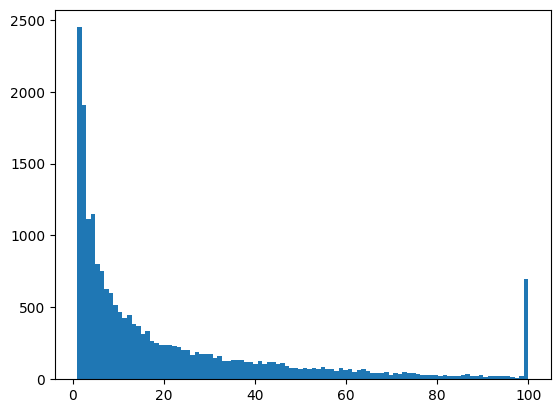

In [5]:
import numpy as np
import matplotlib.pyplot as plt
sum_len=0
len_list=[]
for user in list_users:
  len_list.append(len(user['pos_id']))
  sum_len+=len(user['pos_id'])
print(sum_len/len(list_users))
len_array=np.array(len_list)
print(len_array.mean(),len_array.std(),len_array.max(),len_array.min())
plt.hist(len_array,100)

21.458622016936104
21.458622016936104 25.618203688507787 100 1


(array([2448., 1909., 1118., 1149.,  800.,  753.,  626.,  599.,  516.,
         471.,  427.,  444.,  381.,  369.,  317.,  337.,  267.,  254.,
         239.,  239.,  237.,  234.,  222.,  205.,  206.,  171.,  189.,
         178.,  178.,  173.,  147.,  165.,  130.,  128.,  132.,  133.,
         134.,  118.,  122.,  109.,  130.,  109.,  118.,  122.,  103.,
         116.,   94.,   79.,   77.,   70.,   80.,   74.,   79.,   70.,
          82.,   74.,   69.,   61.,   77.,   64.,   69.,   54.,   65.,
          72.,   59.,   47.,   41.,   43.,   49.,   33.,   46.,   40.,
          49.,   44.,   45.,   34.,   33.,   30.,   31.,   30.,   24.,
          32.,   25.,   25.,   21.,   29.,   37.,   25.,   22.,   31.,
          19.,   26.,   21.,   21.,   21.,   23.,   17.,   12.,   21.,
         696.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  2

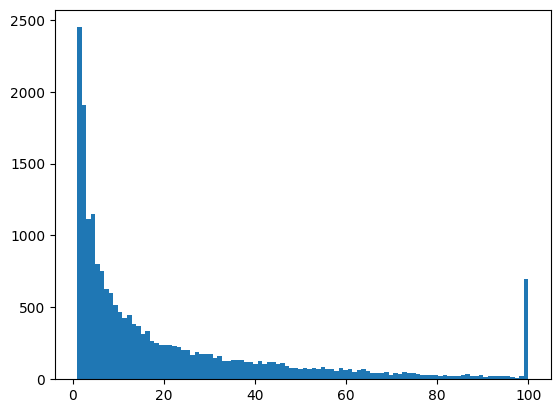

In [6]:
import numpy as np
import matplotlib.pyplot as plt
sum_len=0
len_list=[]
for user in list_users:
  len_list.append(len(user['pos_id']))
  sum_len+=len(user['pos_id'])
print(sum_len/len(list_users))
len_array=np.array(len_list)
print(len_array.mean(),len_array.std(),len_array.max(),len_array.min())
plt.hist(len_array,100)

21.458622016936104
21.458622016936104 25.618203688507787 100 1


(array([2448., 1909., 1118., 1149.,  800.,  753.,  626.,  599.,  516.,
         471.,  427.,  444.,  381.,  369.,  317.,  337.,  267.,  254.,
         239.,  239.,  237.,  234.,  222.,  205.,  206.,  171.,  189.,
         178.,  178.,  173.,  147.,  165.,  130.,  128.,  132.,  133.,
         134.,  118.,  122.,  109.,  130.,  109.,  118.,  122.,  103.,
         116.,   94.,   79.,   77.,   70.,   80.,   74.,   79.,   70.,
          82.,   74.,   69.,   61.,   77.,   64.,   69.,   54.,   65.,
          72.,   59.,   47.,   41.,   43.,   49.,   33.,   46.,   40.,
          49.,   44.,   45.,   34.,   33.,   30.,   31.,   30.,   24.,
          32.,   25.,   25.,   21.,   29.,   37.,   25.,   22.,   31.,
          19.,   26.,   21.,   21.,   21.,   23.,   17.,   12.,   21.,
         696.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  2

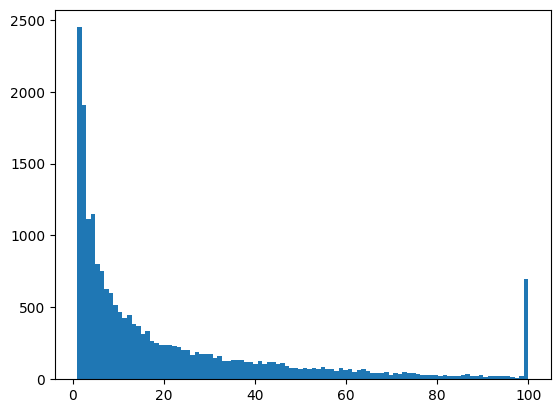

In [7]:
import numpy as np
import matplotlib.pyplot as plt
sum_len=0
len_list=[]
for user in list_users:
  len_list.append(len(user['pos_id']))
  sum_len+=len(user['pos_id'])
print(sum_len/len(list_users))
len_array=np.array(len_list)
print(len_array.mean(),len_array.std(),len_array.max(),len_array.min())
plt.hist(len_array,100)

In [8]:
nb_repeated_end_of_sequence=0
len_1=0
for user in list_users:
  if len(user['pos_id'])==1:
    len_1+=1
    if user['pos_id'][-1]==user['pos_id_target'][-1]:
      nb_repeated_end_of_sequence+=1
print(nb_repeated_end_of_sequence/len_1)

0.0


In [9]:
nb_repeated_end_of_sequence=0
len_1=0
for user in list_users:
  if len(user['pos_id'])==1:
    len_1+=1
    if user['pos_id'][-1]==user['pos_id_target'][-1]:
      nb_repeated_end_of_sequence+=1
print(nb_repeated_end_of_sequence/len_1)

0.0


# Dataset

## Reproducibility seed

In [10]:
import hashlib
import string
import random
def get_reproducible_seeds(name="ProjectLong",nb_seeds=100):
    # Calculate SHA-256 hash
    sha256_hash = hashlib.sha256(name.encode()).hexdigest()
    # Define character sets
    digits = string.digits
    # Use the hash to seed the random number generator
    hash_as_int = int(sha256_hash, 16)
    random.seed(hash_as_int)
    # Generate a random list of seed of desired length
    reproducibility_seeds = [random.randint(0,10000) for _ in range(nb_seeds)]

    return reproducibility_seeds

In [11]:
reproducibility_seed=get_reproducible_seeds()[0]

## Dataset

In [12]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDatasetWithPosID(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series
    def __len__(self):
        return len(self.times_series)
    def __getitem__(self, idx):
        user_dict=self.times_series[idx]
        return  user_dict

def create_dataset(list_users,split=[0.8,0.1,0.1]):
  dataset=VariableLengthDatasetWithPosID(list_users)
  generator = torch.Generator().manual_seed(reproducibility_seed)
  dataset_list=torch.utils.data.random_split(dataset,[0.8,0.1,0.1],generator)
  return dataset_list


## Dataloader

In [13]:
def collate_fn_padd(batch_dict):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''


    dict_batch={key: [d[key] for d in batch_dict] for key in batch_dict[0]}
    dict_batch["lengths"] = torch.tensor([ user["input"].shape[0] for user in batch_dict ])
    if "input" in dict_batch:
      dict_batch["input"] = torch.nn.utils.rnn.pad_sequence(dict_batch["input"],batch_first=True,padding_value=0)
    dict_batch["month"] = torch.nn.utils.rnn.pad_sequence(dict_batch["month"],batch_first=True,padding_value=0)
    dict_batch["day"] = torch.nn.utils.rnn.pad_sequence(dict_batch["day"],batch_first=True,padding_value=0)
    dict_batch["hour"] = torch.nn.utils.rnn.pad_sequence(dict_batch["hour"],batch_first=True,padding_value=24)
    dict_batch["minute"] = torch.nn.utils.rnn.pad_sequence(dict_batch["minute"],batch_first=True,padding_value=60)
    dict_batch["second"] = torch.nn.utils.rnn.pad_sequence(dict_batch["second"],batch_first=True,padding_value=60)

    dict_batch["time_target"] = torch.nn.utils.rnn.pad_sequence(dict_batch["time_target"],batch_first=True,padding_value=-1)
    dict_batch["pos_id"] = torch.nn.utils.rnn.pad_sequence(dict_batch["pos_id"],batch_first=True,padding_value=len(vocab))
    dict_batch["pos_id_target"] = torch.nn.utils.rnn.pad_sequence(dict_batch["pos_id_target"],batch_first=True,padding_value=len(vocab))
    #print(dict_batch["input"])
    return dict_batch

## Instanciate

In [14]:
dataset_list=create_dataset(list_users)
train_dataset=dataset_list[0]
valid_dataset=dataset_list[1]
test_dataset=dataset_list[2]
train_dataloader=DataLoader(train_dataset,batch_size=128,collate_fn=collate_fn_padd,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)

# Model

## Transformer Encoder followed by LSTM

### transformer

In [15]:
def get_mask(bath_size,sequence_length,lengths,device):
  mask=torch.zeros(bath_size,sequence_length).to(device)
  for i, length in enumerate(lengths):
    mask[i,length:]=float('-inf')
  return mask

#### Positional encoding

In [16]:
from torch import nn, Tensor
class VanillaPositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = (x.transpose(0,1) + self.pe[:x.transpose(0,1).size(0)]).transpose(0,1)
        return self.dropout(x)

In [17]:
class LearnablePositionalEncoding(nn.Module):

    def __init__(self,d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.positional_embedding=nn.Embedding(num_embeddings=max_len,embedding_dim= d_model)
    @property
    def device(self):
      return next(self.parameters()).device
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size,seq_len, embedding_dim]``
        """
        x += self.positional_embedding(torch.arange(0,x.shape[1]).to(self.device))
        return self.dropout(x)

In [18]:
def get_PositionalEncoding(d_model: int, dropout: float = 0.1, max_len: int = 2000, learnable=False):
  if learnable:
    return LearnablePositionalEncoding(d_model, dropout, max_len)
  else:
    return VanillaPositionalEncoding(d_model, dropout, max_len)

#### model

In [19]:
class Encoder_Decoder_Transformer(nn.Module):
    def __init__(self,d_model,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
      super().__init__()
      self.transformer=torch.nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers,  dropout=dropout, batch_first=batch_first)
    def forward(self,x,mask,src_key_padding_mask,is_causal):
      return self.transformer(x,
                       x,
                       src_mask=mask,
                       tgt_mask=mask,
                       memory_mask=mask,
                       src_key_padding_mask=src_key_padding_mask,
                       tgt_key_padding_mask=src_key_padding_mask,
                       memory_key_padding_mask=src_key_padding_mask,
                       src_is_causal=is_causal,
                       tgt_is_causal=is_causal,
                       memory_is_causal=is_causal)



def get_Transformer_architecture(d_model,encoder_only=False,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
  if encoder_only:
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,batch_first=batch_first)
    return nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
  else:
    return Encoder_Decoder_Transformer(d_model,num_layers,nhead,dropout,batch_first=batch_first)

### feature embedding

In [20]:
class TimeStampEmbedding(nn.Module):
  def __init__(self,embedding_dim,dropout):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.month_embedding = nn.Embedding(num_embeddings=13,embedding_dim=embedding_dim)
    self.day_embedding = nn.Embedding(num_embeddings=32,embedding_dim=embedding_dim)
    self.hour_embedding = nn.Embedding(num_embeddings=25,embedding_dim=embedding_dim)
    self.minute_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)
    self.second_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)

  def forward(self,dict_batch):
    embedding= self.month_embedding(dict_batch['month'])
    embedding=+ self.day_embedding(dict_batch['day'])
    embedding=+ self.hour_embedding(dict_batch['hour'])
    embedding=+ self.minute_embedding(dict_batch['minute'])
    embedding=+ self.second_embedding(dict_batch['second'])
    return self.dropout(embedding)

In [21]:
class StationIdEmbedding(nn.Module):
  def __init__(self,embedding_dim,nb_of_pos_ids,dropout):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.stationIdEmbedding=nn.Embedding(num_embeddings=nb_of_pos_ids,embedding_dim=embedding_dim)
  def forward(self,dict_batch):
    embedding=self.stationIdEmbedding(dict_batch["pos_id"])
    return self.dropout(embedding)


#### graph_deepLearning

In [22]:
!pip install libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.6 MB/s eta 0:00:00


In [23]:
import os
import torch
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=93357726eb42dd8b1a060dce2de51863558ae69388ec938890ca78cf9372a6dc
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from libpysal.cg import voronoi_frames
from libpysal import weights, examples
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import numpy as np

def get_net(vocab):
  x_array=[key[0] for key in vocab]
  y_array=[key[1] for key in vocab]
  coordinates=np.column_stack((x_array,y_array))
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
  delaunay = weights.Rook.from_dataframe(cells)
  delaunay_graph = delaunay.to_networkx()
  positions = dict(zip(delaunay_graph.nodes, coordinates))
  nx.set_node_attributes(delaunay_graph,positions,"coordinates")
  distance=np.linalg.norm(np.concatenate([delaunay_graph.nodes[index[0]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0)-np.concatenate([delaunay_graph.nodes[index[1]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0), axis=1)
  nx.set_edge_attributes(delaunay_graph,dict(zip(delaunay_graph.edges,distance)),"distance")
  net=from_networkx(delaunay_graph)
  return net

class GCN(nn.Module):
  def __init__(self, hidden_dim1, hidden_dim2, output_dim,vocab,dropout,device):
    super(GCN, self).__init__()
    net=get_net(vocab)
    self.dropout = nn.Dropout(p=dropout)
    self.edge_index=edge_index = net.edge_index.long().to(device)
    self.distance= net.distance.float().to(device)
    self.coordinates=net.coordinates.float().to(device)
    mean_distance=self.distance.mean()
    std_distance=self.distance.std()
    self.distance=(((self.distance-mean_distance)/std_distance)+1)/2

    mean_coordinates=self.coordinates.mean(dim=0)
    std_coordinates=self.coordinates.std(dim=0)
    self.coordinates=(self.coordinates-mean_coordinates.unsqueeze(0))/std_coordinates.unsqueeze(0)
    self.conv1 = GCNConv(2, hidden_dim1)
    self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
    self.conv3 = GCNConv(hidden_dim2, output_dim)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self, dic_batch):
    x = self.conv1(self.coordinates, self.edge_index,self.distance)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)

    x = self.conv2(x, self.edge_index,self.distance)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv3(x, self.edge_index,self.distance)
    x=torch.cat((x,torch.zeros(1,x.shape[1]).to(self.device)),dim=0)
    embedding=x[dic_batch["pos_id"]]
    return self.dropout(embedding)


 #### Combine feature embeddng

In [25]:
class Feature_embedding(nn.Module):

  def __init__(self,d_model,nb_of_pos_ids,use_gcn,vocab,hidden_dim1, hidden_dim2,batch_first,concatenate_features,keep_input_positions,dropout,device):
    super().__init__()
    self.num_features=2+use_gcn
    self.concatenate_features=concatenate_features
    self.embedding_dim=d_model
    self.keep_input_positions=keep_input_positions
    if keep_input_positions:
      self.embedding_dim=self.embedding_dim-2
    if self.concatenate_features:
      self.embedding_dim=int(self.embedding_dim/self.num_features)

    list_feature_embedding=[StationIdEmbedding(self.embedding_dim,nb_of_pos_ids,dropout),TimeStampEmbedding(self.embedding_dim,dropout)]
    if use_gcn:
      list_feature_embedding.append(GCN(hidden_dim1, hidden_dim2, self.embedding_dim, vocab, dropout,device))
    self.list_feature_embedding=nn.ModuleList(list_feature_embedding)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self,dic_batch):
    if self.concatenate_features:
      list_embeddings=[]
      for feature_emebdding in self.list_feature_embedding:
        list_embeddings.append(feature_emebdding(dic_batch))
      embedding=torch.cat(list_embeddings,dim=2)
    else:
      embedding=torch.zeros(*dic_batch["pos_id"].shape,self.embedding_dim).to(self.device)
      for feature_emebdding in self.list_feature_embedding:
        embedding+=feature_emebdding(dic_batch)
    if self.keep_input_positions:
      embedding=torch.cat((dic_batch["input"],embedding),dim=2)
    return embedding

### model

In [26]:
from torch import nn
from torch.nn import Embedding, LSTM



class MLP(nn.Module):
  def __init__(self,d_model):
    super().__init__()
    self.dim_perceptron=2*d_model
    self.linear_perceptron_in=nn.Linear(d_model,self.dim_perceptron)
    self.linear_perceptron_out=nn.Linear(self.dim_perceptron,d_model)

  def forward(self,x):
    return self.linear_perceptron_out(F.relu(self.linear_perceptron_in(x)))


class Transformer_LSTM_Layer(nn.Module):
  def __init__(self,d_model,output_regression_size,output_classfication_size,num_layers,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,batch_first):
    super().__init__()

    self.lstm=LSTM(input_size=d_model, hidden_size=d_model,batch_first=batch_first,num_layers=1,dropout=dropout)
    self.lstm_layer_with_perceptron=lstm_layer_with_perceptron
    self.lstm_layer_with_layer_norm=lstm_layer_with_layer_norm
    if self.lstm_layer_with_layer_norm:
      self.layer_normalisation=torch.nn.LayerNorm(d_model)
    if self.lstm_layer_with_perceptron:
      self.mlp=MLP(d_model)
    self.dropout=nn.Dropout(p=dropout)

  def forward(self,x,batch_sizes,sorted_indices,unsorted_indices,lengths):
    x=self.lstm(x)[0].data+x.data
    x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
    if self.lstm_layer_with_layer_norm:
      x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
      x=self.layer_normalisation(x)
      x=self.dropout(x)
      x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    if self.lstm_layer_with_perceptron:
      x=x.data
      x=self.mlp(x)+x
      x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
      if self.layer_normalisation:
        x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
        x=self.layer_normalisation(x)
        x=self.dropout(x)
        x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    return x






class  Transformer_encoder_LSTM_decoder(nn.Module):
  def __init__(self,d_model,nb_of_pos_ids,output_regression_size,output_classfication_size,num_layers_lstm,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,num_layers_transformer,encoder_only,nhead,learnable_pos_encoding,new_station_binary_classification,use_gcn,vocab,hidden_dim1, hidden_dim2,max_len,dropout,batch_first,concatenate_features,keep_input_positions,device):
    super().__init__()
    self.dropout=nn.Dropout(p=dropout)
    self.layer_normalisation=torch.nn.LayerNorm(d_model)
    self.feature_embedding=Feature_embedding(d_model,nb_of_pos_ids,use_gcn,vocab,hidden_dim1, hidden_dim2,batch_first,concatenate_features,keep_input_positions,dropout,device)

    self.num_layers_transformer=num_layers_transformer
    if num_layers_transformer>0:
      self.pos_encoder = get_PositionalEncoding(d_model, dropout, max_len,learnable_pos_encoding)
      self.transformer_model=get_Transformer_architecture(d_model,encoder_only,num_layers_transformer,nhead,dropout,batch_first)

    self.num_layers_lstm=num_layers_lstm
    if num_layers_lstm>0:
      self.transformer_lstm__list = nn.ModuleList([Transformer_LSTM_Layer(d_model,output_regression_size,output_classfication_size,num_layers_lstm,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,batch_first) for layer in range(num_layers_lstm)])
    self.linear_reg=nn.Linear(d_model,output_regression_size)
    self.classifier=nn.Linear(d_model,output_classfication_size)

    self.new_station_binary_classification=new_station_binary_classification
    if self.new_station_binary_classification:
      self.binary_classifier=nn.Linear(d_model,1)

  @property
  def device(self):
    return next(self.parameters()).device


  def forward(self,dic_batch,reg):
    if self.num_layers_transformer>0:
      x=self.feature_embedding(dic_batch)
      x=self.pos_encoder(x)
      with torch.no_grad():
        mask_x = get_mask(x.shape[0],x.shape[1],dic_batch["lengths"],self.device)
        causal_mask=torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1],device=self.device)
      x=self.transformer_model(x,causal_mask,mask_x,is_causal=True)
    if self.num_layers_lstm>0:
      if self.num_layers_transformer>0:
        x+=self.feature_embedding(dic_batch)
      else:
        x=self.feature_embedding(dic_batch)

    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    batch_sizes=x.batch_sizes
    sorted_indices=x.sorted_indices
    unsorted_indices=x.unsorted_indices
    if self.num_layers_lstm>0:
      for transformer_lstm in self.transformer_lstm__list:
        x=transformer_lstm(x,batch_sizes,sorted_indices,unsorted_indices,dic_batch["lengths"])
    x=F.relu(x.data)
    out={}
    out["next_station"]=torch.nn.utils.rnn.PackedSequence(self.classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    if reg:
      out["time_regression"]=torch.nn.utils.rnn.PackedSequence(torch.exp(self.linear_reg(x)), batch_sizes, sorted_indices, unsorted_indices)
    if self.new_station_binary_classification:
      out["new_station"]=  torch.nn.utils.rnn.PackedSequence( self.binary_classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    return out



## Baselines

In [ ]:
from torch import nn
import torch.nn.functional as F
class  Baseline_model(nn.Module):
  def __init__(self,nb_of_pos_ids):
    super().__init__()
    self.nb_of_pos_ids=nb_of_pos_ids
  def forward(self,dic_batch,reg):
    out={}
    out["next_station"]=  torch.nn.utils.rnn.pack_padded_sequence(F.one_hot(dic_batch["pos_id"],self.nb_of_pos_ids).float(), lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    return out

In [ ]:
model=Baseline_model(len(vocab)+1)
criterion=Total_loss(False)
evaluate(model,valid_dataloader,criterion,device,reg=False)

{'classification': 0.0021053161556483374,
 'total': 0.0021053161556483374,
 'acc': 0.044894637279486165}

# Trainning

In [27]:
# @title loss
from torch import nn
class Loss_next_station_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))

  def forward(self, out, target_pos_ids, index_training_element):
    loss_classification=self.criterion(out.data[index_training_element],target_pos_ids.data[index_training_element])
    return loss_classification

class Loss_time_regression(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion = nn.MSELoss(reduction='none')
  def forward(self,out,dict_batch):
    time_targets=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["time_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    mask_time_targets = (time_targets.data != -1)
    loss_regression=self.criterion(out.data,time_targets.data)
    loss_regression = (loss_regression * mask_time_targets.float()).mean()
    return loss_regression

class Loss_new_station_binary_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion =  nn.BCEWithLogitsLoss()
  def forward(self,out,target):
    loss_classification=self.criterion(out.data.squeeze(),target.float())
    return loss_classification

def get_repetition_labels(target_pos_ids,pos_ids):

  return (target_pos_ids.data==pos_ids.data).type(torch.LongTensor)

def upsampling_strategy(target, epoch, epochs_new_station_only,pourcentage_of_repeat_training_elment):

    index_non_repeat =(target==0).nonzero()
    coeff=pourcentage_of_repeat_training_elment/(1-pourcentage_of_repeat_training_elment)
    index_for_training= index_non_repeat
    if epoch>= epochs_new_station_only:
      index_repeat = target.nonzero().squeeze()
      nb_non_repeat= index_non_repeat.shape[0]
      slice_repeat=index_repeat[torch.randperm(index_repeat.shape[0])[:int(coeff*nb_non_repeat)]].squeeze()
      index_for_training = torch.cat((index_non_repeat.squeeze(),slice_repeat))
    return index_for_training.squeeze()


class Total_loss(nn.Module):
  def __init__(self,new_station_binary_classification) -> None:
    super().__init__()
    self.loss_next_station_classification = Loss_next_station_classification()
    self.loss_time_regression = Loss_time_regression()
    self.new_station_binary_classification=new_station_binary_classification
    if self.new_station_binary_classification:
      self.loss_new_station_binary_classification=Loss_new_station_binary_classification()

  def forward(self, out, dict_batch, upsampling,upsampling_strategy, reg=False):
    loss={}
    target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    if self.new_station_binary_classification or upsampling:
      pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
      target=get_repetition_labels(target_pos_ids,pos_ids)
    else:
      pos_ids=None
      target=None

    if upsampling:
      index_training_element=upsampling_strategy(target)
    else:
      index_training_element=torch.arange(0,target_pos_ids.data.shape[0])

    loss["classification"]=self.loss_next_station_classification(out["next_station"],target_pos_ids,index_training_element)
    loss["total"]=loss["classification"]
    if self.new_station_binary_classification:
      loss["new_station"]=self.loss_new_station_binary_classification(out["new_station"],target)
      loss["total"]+=loss["new_station"]

    if reg:
      loss["time_regression"]=self.loss_time_regression(out["time_regression"],dict_batch)
      loss["total"]+=loss["time_regression"]

    return loss





In [28]:
# @title evaluation
from torch import autocast
def evaluate(model,dataloader,upsampling,criterion,device,reg=True):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        valid_result=criterion(out,dict_batch,upsampling,None,reg=reg)
        valid_results=get_sum_valid_results(valid_results,valid_result)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
    valid_results=get_mean_valid_results(valid_results,nb_points)
    valid_results["acc"]=acc/nb_points

    return valid_results

In [29]:
# @title training
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
def train(
          epochs_classifcation_only,
          epochs_complete_problem,
          input_size,
          num_heads,
          d_model,
          nb_of_pos_ids,
          num_layers_lstm,
          lstm_layer_with_perceptron,
          lstm_layer_with_layer_norm,
          num_layers_transformer,
          encoder_only,
          output_regression_size,
          output_classfication_size,
          nb_batchs,
          dropout,
          max_len,
          weight_decay,
          lr,
          learnable_pos_encoding,
          new_station_binary_classification,
          use_gcn,
          vocab,hidden_dim1, hidden_dim2,
          batch_first,
          concatenate_features,
          keep_input_positions,
          upsampling,
          upsampling_strategy,
          epochs_new_station_only,
          pourcentage_of_repeat_training_elment,
          save_best_model,
          path_best_model,
          batch_size,
          device):

  epochs=epochs_complete_problem+ epochs_classifcation_only
  model=Transformer_encoder_LSTM_decoder(d_model=d_model,
                                         nb_of_pos_ids=nb_of_pos_ids,
                                         output_regression_size=output_regression_size,
                                         output_classfication_size=output_classfication_size,
                                         num_layers_lstm=num_layers_lstm,
                                         lstm_layer_with_perceptron=lstm_layer_with_perceptron,
                                         lstm_layer_with_layer_norm=lstm_layer_with_perceptron,
                                         num_layers_transformer=num_layers_transformer,
                                         encoder_only=encoder_only,
                                         nhead=num_heads,
                                         learnable_pos_encoding=learnable_pos_encoding,
                                         new_station_binary_classification=new_station_binary_classification,
                                         use_gcn=use_gcn,
                                         vocab=vocab,
                                         hidden_dim1=hidden_dim1,
                                         hidden_dim2=hidden_dim2,
                                         max_len=max_len,
                                         dropout=dropout,
                                         batch_first = batch_first,
                                         concatenate_features = concatenate_features,
                                         keep_input_positions = keep_input_positions,device=device
                                         ).to(device)
  if save_best_model:
    os.makedirs(path_best_model,exist_ok =True)
  optimizer_encoder = optim.Adam( model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = Total_loss( new_station_binary_classification = new_station_binary_classification)
  train_losses, valid_results = {},{}
  best_results={}
  for epoch in range(epochs):
    reg=epoch >= epochs_classifcation_only
    epoch_losses={}
    model.train()
    i=0
    for dict_batch in train_dataloader:
      optimizer_encoder.zero_grad()
      i+=1
      if i>=nb_batchs:
        break
      dict_batch=set_dic_to(dict_batch,device)
      with autocast(device_type=device.type):
        out=model(dict_batch, reg)
        loss=criterion(out, dict_batch,upsampling,lambda target: upsampling_strategy(target,epoch,epochs_new_station_only,pourcentage_of_repeat_training_elment) ,reg)
        loss["total"].backward()
        optimizer_encoder.step()
      epoch_losses=update_epoch_losses(epoch_losses,loss)
      dict_batch.clear()
      loss.clear()
      out.clear()
      del out, loss,dict_batch
    epoch_loss=get_epoch_loss(epoch_losses,batch_size)
    train_losses=update_train_losses(train_losses,epoch_loss,epoch)
    valid_result = evaluate(model,valid_dataloader,upsampling,criterion,device)
    best_results = update_best(model,valid_result,best_results,save_best_model,path_best_model)
    valid_results = update_valid_results(valid_results,valid_result)
    print_results(epoch_loss,valid_result,epoch)

  return best_results

In [30]:
# @title utils

def set_dic_to(dict_batch,device):
  for key in dict_batch:
    if key!="lengths":
      dict_batch[key]=dict_batch[key].to(device)
  return dict_batch

def is_better(valid_result,best_result,key):
  match key:
    case "acc":
      return valid_result>best_result
    case _:
      return valid_result<best_result

def update_best(model,valid_result,best_results,save_best_model,path_best_model):
  if best_results:
    for key in valid_result:
      if is_better(valid_result[key],best_results[key],key):
        best_results[key]=valid_result[key]
        if save_best_model:
          save_model(model,path_best_model,key)
  else:
    for key in valid_result:
      best_results[key]=valid_result[key]
      if save_best_model:
        save_model(model,path_best_model,key)
  return best_results

def save_model(model,path_best_model,key):
  path=os.path.join(path_best_model,key)
  torch.save(model.state_dict(), path+".pth")

def get_sum_valid_results(valid_result,valid_result_batch):
  if valid_result:
    for key in valid_result_batch:
      valid_result[key]+=valid_result_batch[key].item()
  else:
    for key in valid_result_batch:
      valid_result[key]=valid_result_batch[key].item()
  return valid_result

def get_mean_valid_results(sum_valid_result,nb_element):
  for key in sum_valid_result:
    sum_valid_result[key]/=nb_element

  return sum_valid_result

def update_epoch_losses(dict_of_list,dic):
  if dict_of_list:
    for key in dic:
      dict_of_list[key].append(dic[key].item())
  else:
    for key in dic:
      dict_of_list[key]=[dic[key].item()]
  return dict_of_list

def update_valid_results(dict_of_list,dic):
  if dict_of_list:
    for key in dic:
      dict_of_list[key].append(dic[key])
  else:
    for key in dic:
      dict_of_list[key]=[dic[key]]
  return dict_of_list

def get_epoch_loss(epoch_losses,batch_size):

  epoch_loss={}
  for key in epoch_losses:
    epoch_loss[key]=np.array(epoch_losses[key]).mean()/batch_size
  return epoch_loss

def print_results(epoch_loss,valid_result,epoch):

  print("\nepoch: ",epoch)
  print("train :", end="\t")
  for key in epoch_loss:
    print(key,epoch_loss[key], end="\t")
  print("\nvalid :", end="\t")
  for key in valid_result:
    print(key,valid_result[key], end="\t")

def update_train_losses(train_losses,epoch_loss,epoch):

  if train_losses:
    for key in epoch_loss:
      if key in train_losses:
        train_losses[key].append(epoch_loss[key])
      else:
        train_losses[key]=[float('nan')]*(epoch+1)+[epoch_loss[key]]
  else:
    for key in epoch_loss:
      train_losses[key]=[epoch_loss[key]]
  return train_losses

## Instance of training

In [31]:
# @title Titre par défaut
model=train(
          epochs_classifcation_only=100,
          epochs_complete_problem =100,
          input_size=2,
          num_heads=12,
          d_model=1200,
          nb_of_pos_ids=len(vocab)+1,
          num_layers_lstm=6,
          lstm_layer_with_perceptron=False,
          lstm_layer_with_layer_norm=False,
          num_layers_transformer=6,
          encoder_only=True,
          output_regression_size=2,
          output_classfication_size=len(vocab)+1,
          nb_batchs=100,
          dropout=0.1,
          max_len=100,
          weight_decay=0,
          lr=3e-4,
          learnable_pos_encoding=True,
          new_station_binary_classification=False,
          use_gcn=False,
          vocab=vocab, hidden_dim1=128, hidden_dim2=256,
          batch_first= True,
          concatenate_features = False,
          keep_input_positions = False,
          upsampling=False,
          upsampling_strategy=upsampling_strategy,
          epochs_new_station_only=0,
          pourcentage_of_repeat_training_elment=0.1,
          save_best_model=True,
          path_best_model="test_0.5",
          device=device,
          batch_size=64
          )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


KeyboardInterrupt: 

# hyperparameter tuning

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from libpysal.cg import voronoi_frames
from libpysal import weights, examples
from torch_geometric.utils import from_networkx
from torch_geometric.nn.models import GCN,GAT,GraphSAGE
import numpy as np

def get_net(vocab):
  x_array=[key[0] for key in vocab]
  y_array=[key[1] for key in vocab]
  coordinates=np.column_stack((x_array,y_array))
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
  delaunay = weights.Rook.from_dataframe(cells)
  delaunay_graph = delaunay.to_networkx()
  positions = dict(zip(delaunay_graph.nodes, coordinates))
  nx.set_node_attributes(delaunay_graph,positions,"coordinates")
  distance=np.linalg.norm(np.concatenate([delaunay_graph.nodes[index[0]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0)-np.concatenate([delaunay_graph.nodes[index[1]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0), axis=1)
  nx.set_edge_attributes(delaunay_graph,dict(zip(delaunay_graph.edges,distance)),"distance")
  net=from_networkx(delaunay_graph)
  return net
def get_layer(layer_type):
  print(layer_type)
  match layer_type:
    case "GraphSAGE":
      return GraphSAGE
    case "GCNConv":
      return GCN
    case "GAT":
      return GAT

class GCN(nn.Module):
  def __init__(self,output_dim,dropout,layer_type,num_layers_gcn,hidden_channels,activation_gcn,norm,net,device):
    super(GCN, self).__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.edge_index=edge_index = net.edge_index.long().to(device)
    self.distance= net.distance.float().to(device)
    self.coordinates=net.coordinates.float().to(device)
    mean_distance=self.distance.mean()
    std_distance=self.distance.std()
    self.distance=(((self.distance-mean_distance)/std_distance)+1)/2

    mean_coordinates=self.coordinates.mean(dim=0)
    std_coordinates=self.coordinates.std(dim=0)
    self.coordinates=(self.coordinates-mean_coordinates.unsqueeze(0))/std_coordinates.unsqueeze(0)

    self.model=get_layer(layer_type)(in_channels=2, out_channels=output_dim, act=activation_gcn, norm=norm, num_layers=num_layers_gcn, hidden_channels=hidden_channels,dropout=dropout)
  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self, dic_batch):
    x = self.model(self.coordinates,self.edge_index,self.distance)
    x=torch.cat((x,torch.zeros(1,x.shape[1]).to(self.device)),dim=0)
    embedding=x[dic_batch["pos_id"]]
    return self.dropout(embedding)

In [33]:

class Feature_embedding(nn.Module):

  def __init__(self,config,net,device):
    super().__init__()
    self.num_features=2+config["use_gcn"]
    self.concatenate_features=config["concatenate_features"]
    self.embedding_dim=config["d_model"]
    if self.concatenate_features:
      self.embedding_dim=int(self.embedding_dim/self.num_features)

    list_feature_embedding=[StationIdEmbedding(self.embedding_dim,config["nb_of_pos_ids"],config["dropout_StationIdEmbedding"]),TimeStampEmbedding(self.embedding_dim,config["dropout_timeStampEmbedding"])]
    if config["use_gcn"]:
      list_feature_embedding.append(GCN( self.embedding_dim,config["dropout_gcn"],config["layer_type"],config["num_layers_gcn"],config["hidden_channels"],config["activation_gcn"],config["norm"],net,device))
    self.list_feature_embedding=nn.ModuleList(list_feature_embedding)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self,dic_batch):
    if self.concatenate_features:
      list_embeddings=[]
      for feature_emebdding in self.list_feature_embedding:
        list_embeddings.append(feature_emebdding(dic_batch))
      embedding=torch.cat(list_embeddings,dim=2)
    else:
      embedding=torch.zeros(*dic_batch["pos_id"].shape,self.embedding_dim).to(self.device)
      for feature_emebdding in self.list_feature_embedding:
        embedding+=feature_emebdding(dic_batch)

    return embedding


In [34]:
class Encoder_Decoder_Transformer(nn.Module):
    def __init__(self,d_model,num_layers_transformer,num_heads,dropout_transformers,activation_transformers,batch_first=True):
      super().__init__()
      self.transformer=torch.nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=num_layers_transformer, num_decoder_layers=num_layers_transformer, dropout=dropout_transformers,activation=get_activation(activation_transformers), batch_first=batch_first)
    def forward(self,x,mask,src_key_padding_mask,is_causal):
      return self.transformer(x,
                       x,
                       src_mask=mask,
                       tgt_mask=mask,
                       memory_mask=mask,
                       src_key_padding_mask=src_key_padding_mask,
                       tgt_key_padding_mask=src_key_padding_mask,
                       memory_key_padding_mask=src_key_padding_mask,
                       src_is_causal=is_causal,
                       tgt_is_causal=is_causal,
                       memory_is_causal=is_causal)



def get_Transformer_architecture(d_model,encoder_only,num_layers_transformer,num_heads,dropout_transformers,activation_transformers,batch_first=True):
  if encoder_only:
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads,batch_first=batch_first,activation=get_activation(activation_transformers),dropout=dropout_transformers)
    return nn.TransformerEncoder(encoder_layer, num_layers=num_layers_transformer)
  else:
    return Encoder_Decoder_Transformer(d_model,num_layers_transformer,num_heads,dropout_transformers,activation_transformers,batch_first=batch_first)

In [35]:
# @title Model
from torch import nn
from torch.nn import Embedding, LSTM



class MLP(nn.Module):
  def __init__(self,d_model,activation_lstm):
    super().__init__()
    self.dim_perceptron=2*d_model
    self.linear_perceptron_in=nn.Linear(d_model,self.dim_perceptron)
    self.linear_perceptron_out=nn.Linear(self.dim_perceptron,d_model)
    self.activation=get_activation(activation_lstm)
  def forward(self,x):
    return self.linear_perceptron_out(self.activation(self.linear_perceptron_in(x)))


class Transformer_LSTM_Layer(nn.Module):
  def __init__(self,d_model,output_regression_size,output_classfication_size,num_layers,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,activation_lstm,batch_first):
    super().__init__()

    self.lstm=LSTM(input_size=d_model, hidden_size=d_model,batch_first=batch_first,num_layers=1,dropout=dropout)
    self.lstm_layer_with_perceptron=lstm_layer_with_perceptron
    self.lstm_layer_with_layer_norm=lstm_layer_with_layer_norm
    if self.lstm_layer_with_layer_norm:
      self.layer_normalisation=torch.nn.LayerNorm(d_model)
    if self.lstm_layer_with_perceptron:
      self.mlp=MLP(d_model,activation_lstm)
    self.dropout=nn.Dropout(p=dropout)

  def forward(self,x,batch_sizes,sorted_indices,unsorted_indices,lengths):
    x=self.lstm(x)[0].data+x.data
    x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
    if self.lstm_layer_with_layer_norm:
      x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
      x=self.layer_normalisation(x)
      x=self.dropout(x)
      x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    if self.lstm_layer_with_perceptron:
      x=x.data
      x=self.mlp(x)+x
      x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
      if self.lstm_layer_with_layer_norm:
        x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
        x=self.layer_normalisation(x)
        x=self.dropout(x)
        x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    return x
class Abs(nn.Module):
  def __init__(self,):
    super().__init__()
  def forward(self,x):
    return torch.abs(x)

class Exp(nn.Module):
  def __init__(self,):
    super().__init__()
  def forward(self,x):
    return torch.exp(x)

class Sig(nn.Module):
  def __init__(self,):
    super().__init__()
  def forward(self,x):
    return torch.sigmoid(x)


def get_positive_function(config):
  match config["positive_function"]:
    case "relu":
      return nn.ReLU()
    case "abs":
      return Abs()
    case "exp":
      return Exp()
    case "sig":
      return Sig()


def get_activation(activation):
  match activation:
    case "ReLU":
      return nn.ReLU()
    case "Tanh":
      return nn.Tanh()
    case "LeakyReLU":
      return nn.LeakyReLU()
    case "SiLU":
      return nn.SiLU()
    case "GELU":
      return nn.GELU()
    case "ELU":
      return nn.ELU()
    case "Mish":
      return nn.Mish()
    case "ReLU6":
      return nn.ReLU6()
    case "PReLU":
      return nn.PReLU()
    case "SELU":
      return nn.SELU()
    case "CELU":
      return nn.CELU()
    case "Hardsigmoid":
      return nn.Hardsigmoid()
    case "Softplus":
      return nn.Softplus()
    case "Hardshrink":
      return nn.Hardshrink()
    case "Sigmoid":
      return nn.Sigmoid()
    case "Hardtanh":
      return nn.Hardtanh()
    case "Tanhshrink":
      return nn.Tanhshrink()
    case "RReLU":
      return nn.RReLU()
    case "Softshrink":
      return nn.Softshrink()
    case "Softsign":
      return nn.Softsign()
    case "LogSigmoid":
      return nn.LogSigmoid()
    case "Softmin":
      return nn.Softmin()
    case "Hardswish":
      return nn.Hardswish()

class  Transformer_encoder_LSTM_decoder(nn.Module):
  def __init__(self,config,net,device):
    super().__init__()
    self.dropout=nn.Dropout(p=config["dropout"])
    self.layer_normalisation=torch.nn.LayerNorm(config["d_model"])
    self.feature_embedding=Feature_embedding(config,net,device)
    self.activation=get_activation(config["activation"])
    if config["reg"]:
      self.positive_function=get_positive_function(config)
    self.transformers_model=config["transformers_model"]
    if self.transformers_model>0:
      self.num_layers_transformer=config["num_layers_transformer"]
      self.pos_encoder = get_PositionalEncoding(config["d_model"], config["dropout_transformers"], 100,config["learnable_pos_encoding"])
      self.transformer_model=get_Transformer_architecture(config["d_model"],config["encoder_only"],config["num_layers_transformer"],config["num_heads"],config["dropout_transformers"],config["activation_transformers"],True,)

    self.lstm_model=config["lstm_model"]
    if self.lstm_model>0:
      self.num_layers_lstm=config["num_layers_lstm"]
      self.transformer_lstm__list = nn.ModuleList([Transformer_LSTM_Layer(config["d_model"],2,config["nb_of_pos_ids"],config["num_layers_lstm"],config["lstm_layer_with_perceptron"],config["lstm_layer_with_layer_norm"],config["dropout_lstm"],config["activation_lstm"],True) for layer in range(config["num_layers_lstm"])])
    self.linear_reg=nn.Linear(config["d_model"],2)
    self.classifier=nn.Linear(config["d_model"],config["nb_of_pos_ids"])

  @property
  def device(self):
    return next(self.parameters()).device


  def forward(self,dic_batch,reg):
    if self.transformers_model:
      x=self.feature_embedding(dic_batch)
      x=self.pos_encoder(x)
      with torch.no_grad():
        mask_x = get_mask(x.shape[0],x.shape[1],dic_batch["lengths"],self.device)
        causal_mask=torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1],device=self.device)
      x=self.transformer_model(x,causal_mask,mask_x,is_causal=True)
    if self.lstm_model:
      if self.transformers_model>0:
        x+=self.feature_embedding(dic_batch)
      else:
        x=self.feature_embedding(dic_batch)
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    batch_sizes=x.batch_sizes
    sorted_indices=x.sorted_indices
    unsorted_indices=x.unsorted_indices
    if self.lstm_model>0:
      for transformer_lstm in self.transformer_lstm__list:
        x=transformer_lstm(x,batch_sizes,sorted_indices,unsorted_indices,dic_batch["lengths"])
    x=self.activation(x.data)
    out={}
    out["next_station"]=torch.nn.utils.rnn.PackedSequence(self.classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    if reg:
      out["time_regression"]=torch.nn.utils.rnn.PackedSequence(self.positive_function(self.linear_reg(x)), batch_sizes, sorted_indices, unsorted_indices)
    return out

In [36]:
from torch import autocast
def evaluate(model,dataloader,device,reg=False):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
    acc=acc/nb_points
    return acc

In [37]:
# @title loss
from torch import nn
class Loss_next_station_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion=torch.nn.CrossEntropyLoss()

  def forward(self, out, target_pos_ids):
    loss_classification=self.criterion(out.data,target_pos_ids.data)
    return loss_classification

class Loss_time_regression(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion = nn.MSELoss(reduction='none')
  def forward(self,out,dict_batch):
    time_targets=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["time_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    mask_time_targets = (time_targets.data != -1)
    loss_regression=self.criterion(out.data,time_targets.data)
    loss_regression = (loss_regression * mask_time_targets.float()).mean()
    return loss_regression

class Total_loss(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.loss_next_station_classification = Loss_next_station_classification()
    self.loss_time_regression = Loss_time_regression()

  def forward(self, out, dict_batch, reg=False):
    target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    loss_classification=self.loss_next_station_classification(out["next_station"],target_pos_ids)
    loss_total=loss_classification
    if reg:
      loss_time_regression=self.loss_time_regression(out["time_regression"],dict_batch)
      loss_total+=loss_time_regression
    return loss_total

In [38]:
# @title utils

def f_unpack_dict(dct):
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v

    return res

def get_file_name(name,path="."):
  exist=True
  idx=0
  while exist:
    file_path=os.path.join(path,name+"_"+str(idx))
    exist=os.path.exists(file_path)
    idx+=1
  return file_path


def get_last_file_name(name,path="."):
  exist=True
  idx=0
  file_path=None
  while exist:
    last_file=file_path
    file_path=os.path.join(path,name+"_"+str(idx))
    exist=os.path.exists(file_path)
    idx+=1
  return last_file

def get_file_name_2(name,path="."):
  exist=True
  i=1
  for file_or_folder in os.listdir(path):
    if os.path.isfile(os.path.join(path,file_or_folder)) and file_or_folder.startswith(name):
        idx=file_or_folder.split("_")[-2]
        if idx.isdigit():
          i=max(i,int(idx)+1)
  return os.path.join(path,name+"_"+str(i))


In [48]:
import os
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler,AsyncHyperBandScheduler
from ray.util.accelerators import NVIDIA_TESLA_V100
from hyperopt import hp,Trials
import ray
from ray.tune.search.hyperopt import HyperOptSearch

def get_model(config,net,device):
  return Transformer_encoder_LSTM_decoder(config,net=net,device=device
                                         ).to(device)

def update_best_acc(model,valid_acc,best_acc,nb_epochs_without_improvement):
  if valid_acc > best_acc :
    best_acc=valid_acc
  else:
    nb_epochs_without_improvement+=1
  return best_acc,nb_epochs_without_improvement


def train_(config,model,dataloaders):
  print(config)
  device=get_device()
  epochs= config["epochs_classifcation_only"]
  if config["reg"]:
    epochs+=config["epochs_complete_problem"]
  optimizer_encoder = optim.Adam( model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
  criterion = Total_loss()
  best_acc=-1
  nb_epochs_without_improvement=0
  for epoch in range(epochs):
    reg=epoch >= config["epochs_classifcation_only"]
    epoch_losses=[]
    model.train()
    i=0
    for dict_batch in dataloaders["train"]:
      optimizer_encoder.zero_grad()
      i+=1
      if i>=config["nb_batchs"]:
        break
      dict_batch=set_dic_to(dict_batch,device)
      with autocast(device_type=device.type):
        out=model(dict_batch, reg)
        loss=criterion(out,dict_batch, reg)
        if loss.isnan():
          print("loss is undifined")
          return {"acc": -1}
        loss.backward()

        optimizer_encoder.step()

      epoch_losses.append(loss.item())

      dict_batch.clear()
      out.clear()
      del out, loss, dict_batch
    epoch_loss=np.array(epoch_losses).mean()
    valid_acc = evaluate(model,dataloaders["valid"],device) ##TO DO: modify evaluate to only compute
    best_acc, nb_epochs_without_improvement = update_best_acc(model,valid_acc,best_acc,nb_epochs_without_improvement)
    if config["early_stopping"]< nb_epochs_without_improvement:
      return best_acc

    print("epoch: ", epoch, "loss : ", epoch_loss, "acc: ", valid_acc)
  return best_acc


def get_datasets():
  list_users,vocab=get_processed_data(src_directory_raw_data="drive/MyDrive/Shanghai-Telcome-Six-Months-DataSet",
                                    directory_raw_data='/content/dataset-telecom-6month',
                                    fixed_time_encoding=False,
                                    input_position=True,
                                    full_dataset=True,
                                    spliting_long_sequences=False,
                                    with_repeated_connections=False,
                                    max_sequence_length=100,
                                    min_sequence_size=2,
                                    save=False,
                                    path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",
                                    download=False,
                                    load_dataset_path="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3",)
  net=get_net(vocab)
  reproducibility_seed=get_reproducible_seeds()[0]
  dataset=VariableLengthDatasetWithPosID(list_users)
  generator = torch.Generator().manual_seed(reproducibility_seed)
  dataset_list=torch.utils.data.random_split(dataset,[0.8,0.1,0.1],generator)
  return dataset_list,net,len(vocab)+1

def get_dataloaders(datasets,batch_size):
  train_dataset=datasets[0]
  valid_dataset=datasets[1]
  train_dataloader=DataLoader(train_dataset,batch_size=batch_size,collate_fn=collate_fn_padd,shuffle=True)
  valid_dataloader=DataLoader(valid_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)
  return {"train":train_dataloader,"valid":valid_dataloader}

def eval_config(config,data=None,net=None):
  device=get_device()
  config=f_unpack_dict(config)
  dataloaders=get_dataloaders(data,config["batch_size"])
  if config["use_gcn"]:
    model=get_model(config,net,device)
  else:
    model=get_model(config,None,device)
  best_acc = train_(config,model,dataloaders)
  return {"valid_accuracy": best_acc}

def run_xp(xp_name,storage_path,algo,num_samples=10, max_num_epochs=10, gpus_per_trial=1, test=True):
  os.environ["OMP_NUM_THREADS"] = '1'
  print(os.environ["OMP_NUM_THREADS"])
  datasets,net,nb_of_pos_ids=get_datasets()
  ray.shutdown()
  config_dict= {
      "max_len":100,
      "nb_of_pos_ids":nb_of_pos_ids,
      "batch_size":2**hp.uniformint("batch_size",4,7),
      "nb_batchs":25*hp.uniformint("nb_batchs",1,8),
      "early_stopping":hp.uniformint("early_stopping",1,20),
      "epochs_classifcation_only":hp.uniformint("epochs_classifcation_only",0,100),
      "reg_choice":hp.choice("reg_choice",
                      [
                          {"reg":True,"epochs_complete_problem":hp.uniformint("epochs_complete_problem",0,100)},
                          {"reg":False},
                      ]),
      "lr":hp.loguniform("lr",-17,0),
      "weight_decay":hp.loguniform("weight_decay",-17,0),
      "input_size":2,
      "d_model":24*hp.uniformint("d_model",1,60),
      "dropout":hp.uniform("dropout",0,1),
      "dropout_timeStampEmbedding":hp.uniform("dropout_timeStampEmbedding",0,1),
      "dropout_StationIdEmbedding":hp.uniform("dropout_StationIdEmbedding",0,1),
      "normalize_features":hp.choice("normalize_features",["before","after",None]),
      "concatenate_features":hp.choice("concatenate_features",[True,False]),
      "use_gcn_choice":hp.choice("use_gcn_choice",
                        [
                            {"use_gcn":True,
                             "layer_type":hp.choice("layer_type",["GCNConv","GraphSAGE","GAT"]),
                             "num_layers_gcn":hp.uniformint("num_layers",1,10),
                             "activation_gcn": hp.choice("activation_gcn",
                              ['swish', 'ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']
                             ),
                             "norm": hp.choice("norm",
                                               ['BatchNorm', 'GraphNorm', 'LayerNorm', 'PairNorm', 'InstanceNorm']
                             ),
                             "dropout_gcn":hp.uniform("dropout_gcn",0,1),
                             "hidden_channels":2**hp.uniformint("hidden_channels",6,11)
                             },
                            {"use_gcn":False}
                        ]),
      "activation": hp.choice(
                "activation",
                 ['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
      "positive_function":hp.choice("positive_function",["relu","exp","abs","sig"]),
      "transformers_model":True,
      "num_layers_transformer":hp.uniformint("num_layers_transformer",1,6),
      "encoder_only":hp.choice("encoder_only",[True,False]),
      "num_heads":3*2**hp.uniformint('num_heads', 0, 3),
      "learnable_pos_encoding": hp.choice("learnable_pos_encoding",[True,False]),
      "activation_transformers": hp.choice("activation_transformers",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
      "dropout_transformers":hp.uniform("dropout_transformers",0,1),

      "lstm_model_choice": hp.choice("lstm_model_choice",
                                     [{"lstm_model":True,
                                       "num_layers_lstm":hp.uniformint("num_layers_lstm",1,6),
                                       "lstm_layer_with_perceptron":
                                        hp.choice("lstm_layer_with_perceptron",
                                         [{"lstm_layer_with_perceptron":True,
                                           "activation_lstm":hp.choice("activation_lstm",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),},
                                          {"lstm_layer_with_perceptron":False,
                                           "activation_lstm":None}]),
                                       "lstm_layer_with_layer_norm":hp.choice("lstm_layer_with_layer_norm",[True,False]),
                                       "dropout_lstm":hp.uniform("dropout_lstm",0,1),
                                       },
                                      {"lstm_model":False}])}
  if algo==None:
    algo = HyperOptSearch(space=config_dict, metric="valid_accuracy", mode="max", random_state_seed=get_reproducible_seeds()[0])
  trainable_with_gpu = tune.with_resources(eval_config, {"cpu": 2, "gpu": 1})
  tuner = tune.Tuner(
        tune.with_parameters(trainable_with_gpu,data=datasets,net=net),
        tune_config=tune.TuneConfig(
                                search_alg=algo,
                                max_concurrent_trials=1,
                                num_samples=1 if test else num_samples,
                                    ),
        run_config=train.RunConfig(
            name=xp_name,
            storage_path=storage_path,
            verbose=0)
    )
  # To enable GPUs, use this instead:
  results = tuner.fit()
  return results, algo


def save_config_xps_to_drive(xps_name,drive_path,xp_size,xps_number,accuracy_target,max_num_epochs):
  dic_config={
      "xps_name":xps_name,
      "xp_size":xp_size,
      "xps_number":xps_number,
      "current_xp": -1,
      "best_xp": {"idx":-1, "mean_valid_accuracy": -1}
  }
  xps_path=os.path.join(drive_path,xps_name)
  xps_configs= os.path.join(xps_path,"xps_configs")
  os.makedirs(xps_path,exist_ok=True)
  torch.save(dic_config,xps_configs)
  return xps_path,xps_configs


def update_config_dictionnary(xps_configs,best_results,num_xp):

  config_dic=torch.load(xps_configs)
  config_dic["current_xp"]=num_xp
  if config_dic["best_xp"]["mean_test_accuracy"]<best_results:
    config_dic["best_xp"]["mean_test_accuracy"]=best_results
    config_dic["best_xp"]["idx"]=num_xp
  torch.save(config_dic,xps_configs)



def update_and_save(xp_name,xps_path,xps_configs,storage_path,results,algo,num_xp,accuracy_target):
  best_results=results.get_best_result(metric='mean_test_accuracy',mode='max').metrics['mean_test_accuracy']
  accarucy_target_not_reached= best_results< accuracy_target
  update_config_dictionnary(xps_configs,best_results,num_xp)
  shutil.copytree(os.path.join(storage_path,xp_name),os.path.join(xps_path,xp_name),dirs_exist_ok=True)
  if num_xp>=1:
    shutil.rmtree(os.path.join(xps_path,"xp_num_"+str(num_xp-1)))
  shutil.rmtree(os.path.join(storage_path,xp_name))
  return accarucy_target_not_reached


def run_all_xp(xps_name="hyperparameter_tuning_projet_long", algo=None, xp_size=10, xps_number=10, accuracy_target=0.98, max_num_epochs=30, storage_path='/content/',drive_path="/content/drive/MyDrive"):
    accarucy_target_not_reached=True
    num_xp=0
    xps_path,xps_configs=save_config_xps_to_drive(xps_name,drive_path,xp_size,xps_number,accuracy_target,max_num_epochs)
    while num_xp<xps_number and accarucy_target_not_reached:
      xp_name= "xp_num_"+str(num_xp)
      results,algo=run_xp(xp_name,storage_path,algo,num_samples=xp_size, max_num_epochs=max_num_epochs, gpus_per_trial=1, test=False)
      accarucy_target_not_reached=update_and_save(xp_name,xps_path,xps_configs,storage_path,results,algo,num_xp,accuracy_target)
      num_xp+=1

In [ ]:
from hyperopt import hp, pyll
datasets,net,nb_of_pos_ids=get_datasets()
space={
      "max_len":100,
      "nb_of_pos_ids":nb_of_pos_ids,
      "batch_size":2**hp.uniformint("batch_size",4,7),
      "nb_batchs":25*hp.uniformint("nb_batchs",1,8),
      "early_stopping":hp.uniformint("early_stopping",1,20),
      "epochs_classifcation_only":hp.uniformint("epochs_classifcation_only",0,100),
      "reg_choice":hp.choice("reg_choice",
                      [
                          {"reg":True,"epochs_complete_problem":hp.uniformint("epochs_complete_problem",0,100)},
                          {"reg":False},
                      ]),
      "lr":hp.loguniform("lr",-17,0),
      "weight_decay":hp.loguniform("weight_decay",-17,0),
      "input_size":2,
      "d_model":24*hp.uniformint("d_model",1,60),
      "dropout":hp.uniform("dropout",0,1),
      "dropout_timeStampEmbedding":hp.uniform("dropout_timeStampEmbedding",0,1),
      "dropout_StationIdEmbedding":hp.uniform("dropout_StationIdEmbedding",0,1),
      "normalize_features":hp.choice("normalize_features",["before","after",None]),
      "concatenate_features":hp.choice("concatenate_features",[True,False]),
      "use_gcn_choice":hp.choice("use_gcn_choice",
                        [
                            {"use_gcn":True,
                             "layer_type":hp.choice("layer_type",["GCNConv","GraphSAGE","GAT"]),
                             "num_layers_gcn":hp.uniformint("num_layers",1,10),
                             "activation_gcn": hp.choice("activation_gcn",
                              ['swish', 'ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']
                             ),
                             "norm": hp.choice("norm",
                                               ['BatchNorm', 'GraphNorm', 'LayerNorm', 'PairNorm', 'InstanceNorm']
                             ),
                             "dropout_gcn":hp.uniform("dropout_gcn",0,1),
                             "hidden_channels":2**hp.uniformint("hidden_channels",6,11)
                             },
                            {"use_gcn":False}
                        ]),
      "activation": hp.choice(
                "activation",
                 ['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
      "positive_function":hp.choice("positive_function",["relu","exp","abs","sig"]),
      "transformers_model":True,
                                       "num_layers_transformer":hp.uniformint("num_layers_transformer",1,6),
                                       "encoder_only":hp.choice("encoder_only",[True,False]),
                                       "num_heads":3*2**hp.uniformint('num_heads', 0, 3),
                                       "learnable_pos_encoding": hp.choice("learnable_pos_encoding",[True,False]),
                                       "activation_transformers": hp.choice("activation_transformers",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),
                                       "dropout_transformers":hp.uniform("dropout_transformers",0,1),
      "lstm_model_choice": hp.choice("lstm_model_choice",
                                     [{"lstm_model":True,
                                       "num_layers_lstm":hp.uniformint("num_layers_lstm",1,6),
                                       "lstm_layer_with_perceptron":
                                        hp.choice("lstm_layer_with_perceptron",
                                         [{"lstm_layer_with_perceptron":True,
                                           "activation_lstm":hp.choice("activation_lstm",['ReLU6', 'PReLU', 'SELU', 'ELU', 'Mish', 'CELU', 'ReLU', 'Hardsigmoid', 'Tanh', 'LeakyReLU', 'Softplus', 'Hardshrink','Sigmoid', 'Hardtanh', 'SiLU', 'Tanhshrink', 'RReLU', 'Softshrink', 'Softsign', 'LogSigmoid', 'Softmin', 'GELU', 'Hardswish']),},
                                          {"lstm_layer_with_perceptron":False,
                                           "activation_lstm":None}]),
                                       "lstm_layer_with_layer_norm":hp.choice("lstm_layer_with_layer_norm",[True,False]),
                                       "dropout_lstm":hp.uniform("dropout_lstm",0,1),
                                       },
                                      {"lstm_model":False}])}
config=pyll.stochastic.sample(space)
eval_config(config,data=datasets,net=net)

loading already preprocessed data: 
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/list_users
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/vocab


<ipython-input-32-1f082812ff3e>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-32-1f082812ff3e>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-32-1f082812ff3e>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-32-1f082812ff3e>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

CUDA is available. Using GPU.
GAT


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23310593007933533 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


{'activation': 'GELU', 'activation_transformers': 'RReLU', 'batch_size': 128, 'concatenate_features': False, 'd_model': 744, 'dropout': 0.027467872616931954, 'dropout_StationIdEmbedding': 0.8359129075458374, 'dropout_timeStampEmbedding': 0.5970626755280908, 'dropout_transformers': 0.7636900183203755, 'early_stopping': 11, 'encoder_only': True, 'epochs_classifcation_only': 56, 'input_size': 2, 'learnable_pos_encoding': False, 'lr': 1.159615573363344e-06, 'dropout_lstm': 0.23310593007933533, 'lstm_layer_with_layer_norm': False, 'activation_lstm': None, 'lstm_layer_with_perceptron': False, 'lstm_model': True, 'num_layers_lstm': 2, 'max_len': 100, 'nb_batchs': 100, 'nb_of_pos_ids': 3043, 'normalize_features': 'after', 'num_heads': 6, 'num_layers_transformer': 5, 'positive_function': 'exp', 'epochs_complete_problem': 2, 'reg': True, 'transformers_model': True, 'activation_gcn': 'ELU', 'dropout_gcn': 0.26744942840284525, 'hidden_channels': 256, 'layer_type': 'GAT', 'norm': 'InstanceNorm', 'n

In [39]:
run_xp('test',"/content/test",None,num_samples=1, max_num_epochs=10, gpus_per_trial=1, test=True)

1
loading already preprocessed data: 
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/list_users
/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements_3/vocab


<ipython-input-29-0931e4912bd5>:15: FutureWarning: The 'convex hull' option for the 'clip' parameter is deprecated and will be removed in a future release. Use 'convex_hull' instead.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-29-0931e4912bd5>:15: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-29-0931e4912bd5>:15: FutureWarning: The 'return_input' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
<ipython-input-29-0931e4912bd5>:16: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_d

+--------------------------------------------------+
| Configuration for experiment     test            |
+--------------------------------------------------+
| Search algorithm                 SearchGenerator |
| Scheduler                        FIFOScheduler   |
| Number of trials                 1               |
+--------------------------------------------------+

View detailed results here: /content/test/test
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/test`
(eval_config pid=10590) CUDA is available. Using GPU.


2024-03-05 21:26:01,061	ERROR tune_controller.py:1374 -- Trial task failed for trial eval_config_16d28f87
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(TypeError): ray::ImplicitFunc.train() (pid=10590, ip=172.28.0.12, actor_id=f2acafdcbf1bc0b75fd3960001000000, repr=eval_config)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skip


Trial eval_config_16d28f87 errored after 0 iterations at 2024-03-05 21:26:01. Total running time: 20s
Error file: /root/ray_results/test/eval_config_16d28f87_1_activation=CELU,batch_size=32,concatenate_features=False,d_model=1200,dropout=0.2593,dropout_StationIdEmbed_2024-03-05_21-25-40/error.txt


2024-03-05 21:26:01,355	ERROR tune.py:1038 -- Trials did not complete: [eval_config_16d28f87]


(ResultGrid<[
   Result(
     error='RayTaskError(TypeError)',
     metrics={},
     path='/content/test/test/eval_config_16d28f87_1_activation=CELU,batch_size=32,concatenate_features=False,d_model=1200,dropout=0.2593,dropout_StationIdEmbed_2024-03-05_21-25-40',
     filesystem='local',
     checkpoint=None
   )
 ]>,
 <ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch at 0x7e8e7f668a90>)

In [41]:
!pip install "ray[tune]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.1 MB/s eta 0:00:00


## check performance on new station

In [ ]:
def evaluate_repeat(model,dataloader,device,reg=True):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    repeat=0
    not_repeat=0
    correct_not_repeat=0
    correct_repeat=0
    incorrect_not_repeat_as_repeat=0
    incorrect_not_repeat=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
        pred=out["next_station"].data.argmax(dim=1)
        pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        for i in range(len(target_pos_ids.data)):
          if target_pos_ids.data[i]==pos_ids.data[i]:
            repeat+=1

            if target_pos_ids.data[i]==pred[i]:
              correct_repeat+=1
          else:
            not_repeat+=1
            if target_pos_ids.data[i]==pred[i]:
              correct_not_repeat+=1
            if target_pos_ids.data[i]!=pred[i]:
              incorrect_not_repeat+=1

          if pred[i]==pos_ids.data[i] and target_pos_ids.data[i]!=pos_ids.data[i]:
            incorrect_not_repeat_as_repeat+=1
    print(nb_points,"repeat: ",repeat," not_repeat: ",not_repeat," correct_repeat/repeat: ",correct_repeat/repeat," correct_not_repeat/not_repeat: ",correct_not_repeat/not_repeat,incorrect_not_repeat_as_repeat/incorrect_not_repeat)
    return valid_results

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=768,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=0,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6509191238701378  correct_not_repeat/not_repeat:  0.2762021385930769 0.4746223564954683


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=12,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.572683570872406  correct_not_repeat/not_repeat:  0.24545712973693992 0.38929461542920074


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=10,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.5703307491790515  correct_not_repeat/not_repeat:  0.22293411471430757 0.40792435839711844


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.44894038389925184  correct_not_repeat/not_repeat:  0.29502962979160746 0.2873538261112317


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=5,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=6,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7462507193879279  correct_not_repeat/not_repeat:  0.23080623646979073 0.5669490561746645


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.4839957344527574  correct_not_repeat/not_repeat:  0.35011261507511315 0.2974764468371467


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=6,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6290835844138258  correct_not_repeat/not_repeat:  0.26852681988148086 0.44345460524349045


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=5,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.5781001387995531  correct_not_repeat/not_repeat:  0.3046073779274453 0.4137291280148423


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=3,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RuntimeError: Error(s) in loading state_dict for Transformer_encoder_LSTM_decoder:
	Missing key(s) in state_dict: "transformer_model.transformer.encoder.layers.5.self_attn.in_proj_weight", "transformer_model.transformer.encoder.layers.5.self_attn.in_proj_bias", "transformer_model.transformer.encoder.layers.5.self_attn.out_proj.weight", "transformer_model.transformer.encoder.layers.5.self_attn.out_proj.bias", "transformer_model.transformer.encoder.layers.5.linear1.weight", "transformer_model.transformer.encoder.layers.5.linear1.bias", "transformer_model.transformer.encoder.layers.5.linear2.weight", "transformer_model.transformer.encoder.layers.5.linear2.bias", "transformer_model.transformer.encoder.layers.5.norm1.weight", "transformer_model.transformer.encoder.layers.5.norm1.bias", "transformer_model.transformer.encoder.layers.5.norm2.weight", "transformer_model.transformer.encoder.layers.5.norm2.bias", "transformer_model.transformer.decoder.layers.5.self_attn.in_proj_weight", "transformer_model.transformer.decoder.layers.5.self_attn.in_proj_bias", "transformer_model.transformer.decoder.layers.5.self_attn.out_proj.weight", "transformer_model.transformer.decoder.layers.5.self_attn.out_proj.bias", "transformer_model.transformer.decoder.layers.5.multihead_attn.in_proj_weight", "transformer_model.transformer.decoder.layers.5.multihead_attn.in_proj_bias", "transformer_model.transformer.decoder.layers.5.multihead_attn.out_proj.weight", "transformer_model.transformer.decoder.layers.5.multihead_attn.out_proj.bias", "transformer_model.transformer.decoder.layers.5.linear1.weight", "transformer_model.transformer.decoder.layers.5.linear1.bias", "transformer_model.transformer.decoder.layers.5.linear2.weight", "transformer_model.transformer.decoder.layers.5.linear2.bias", "transformer_model.transformer.decoder.layers.5.norm1.weight", "transformer_model.transformer.decoder.layers.5.norm1.bias", "transformer_model.transformer.decoder.layers.5.norm2.weight", "transformer_model.transformer.decoder.layers.5.norm2.bias", "transformer_model.transformer.decoder.layers.5.norm3.weight", "transformer_model.transformer.decoder.layers.5.norm3.bias", "transformer_lstm__list.2.layer_normalisation.weight", "transformer_lstm__list.2.layer_normalisation.bias", "transformer_lstm__list.2.lstm.weight_ih_l0", "transformer_lstm__list.2.lstm.weight_hh_l0", "transformer_lstm__list.2.lstm.bias_ih_l0", "transformer_lstm__list.2.lstm.bias_hh_l0", "transformer_lstm__list.2.mlp.linear_perceptron_in.weight", "transformer_lstm__list.2.mlp.linear_perceptron_in.bias", "transformer_lstm__list.2.mlp.linear_perceptron_out.weight", "transformer_lstm__list.2.mlp.linear_perceptron_out.bias". 

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8564101696062832  correct_not_repeat/not_repeat:  0.09422492401215805 0.8021341316208778


(0.643730131126935, 2.2387092113494873, 4.385555267333984)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6269508107925116  correct_not_repeat/not_repeat:  0.24020904856661782 0.4275024463247568


(0.5190344566683142, 3.329756021499634, 2.0473709106445312)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7019025694844104  correct_not_repeat/not_repeat:  0.2555815529946863 0.5174044590664747


(0.5773612306040138, 2.5278093814849854, 2.7385761737823486)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7179745421307424  correct_not_repeat/not_repeat:  0.2436203013273272 0.5562012142237641


(0.5856108172094187, 2.1441447734832764, 1.2037302255630493)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8789227800534886  correct_not_repeat/not_repeat:  0.11254947409853272 0.8136211314803864


(0.6650741059388481, 1.82258939743042, 2.1341636180877686)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8187565591252243  correct_not_repeat/not_repeat:  0.1462683956178522 0.7372573126376722


(0.6311055788439596, 2.027265787124634, 2.6414260864257812)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.3789143166661024  correct_not_repeat/not_repeat:  0.3284642802475345 0.28316509280364704


(0.3648367472709855, 2.700303077697754, 3.602348566055298)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.4562527506009005  correct_not_repeat/not_repeat:  0.30379829874702063 0.3240153275959545


(0.4137118868488654, 2.806699752807617, 3.5753602981567383)

## clean cache

In [40]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.memory_allocated()

5605595648